# Federated Training SCL and GFR datasets with Hyperprameter Optimisation

This notebook exhibits training the SimFL model on on both datasets. The intention of this is to provide a benchmark for us to better understand our federated learning results. We follow through the following phases:

- establishing our environment
- preprocessing the data
- training our model with hyperparameter optimisation
- evaluating our model
- providing predictions on test data


## Establishing our Remote Execution Environment

First we log in to the SAIL backend. This allows us to query for our contracts of interest to see if any remote execution VMs have been initialised for them. We push our safe functions to the respective remote execution VMs and then query for details of the tables they hold. They should both hold unique but valid tables to be processed into training data.  

In [1]:
from sail.core import VMSetup, registersafeobj,login,connect,pushsafeobj,querydata,get_fns
from sail.data import RemoteDataFrame, Utils, RemoteSeries
from sail.algo import fdxgb

from sail.tmp import shap_private, get_tmp_fns

In [2]:
import time

In [3]:
import json, requests
soPath = "/Engineering/Milestone3/EndPointTools/SafeObjectEditor/KPMG/safeobjects"
backendIP = "20.185.6.111"

registersafeobj(soPath)
print("[P]safe objects registered")

[P]safe objects registered


In [4]:
from sail.core import login
eosb = login("adam.hall@secureailabs.com", "-OJBFE2qw-OJBFE2qw", 6200, backendIP)
print("[P]login success")
print(eosb)

[P]login success
5iEQAhtloSOuIxgrcwiyVggiV3v5ZehgMMkf3TmHr3zZLY+sz5+6/ZMNQl2utIFaTaKd4yYDAADPBRUAInF9gPd7HhdanXdsdlDN+49tokfdycIxNm7w3msTdspnQZfwQycTgGnCgWexc09hffoaOzOcWYrVbtYZNo+ikUXkfX+zR1qz2yY9X6tNOunwIRlyi2aIvHurrLau+pQepAFQAk5KfWACftig/fGWlVHWM8S2zDtdHNM8QgJdMraSVgPXzjWnX5d+fwan+6H+G1ITj99lBrO3UM/8RtRuLpX/2WEFPgWAKbG3aN1ZdV5chqVOuv3mYipsCFNb/Jpinle9GXbBolaDBL5qQ73PBTt0zHMD9cZjNbf602K1O+CfDXR4yNp9bD+XkNiFjlv/7lnIDJDOeZKMp4tv4fogv8OJG4e3SZUwlmzFevtwnpruMMaP7nZmmJT5YHWm7kzvWpuQkkzbg3NFtKpXEAedOOwunPFVLl0KCMlI71xWKycimVolvH4EgDEwcP9VxhGby27qtlWfcjBTrNcZ37dMa+nprhyZVTHpIJCmtWIQBUec6pIJkHc6XF8wkyb8CcsElpChA+P3hOxSB/BVuhfJ58hCPKYsQ5Dm+bJmiyf9WnEzX6M7gaDSCYa1k9+kGN08xWpls5/q1MuyvdmS2rr60jOuJlX0ehmBxCv9UwCsIB4KfZqWo24nPfJ38bWQ95zAoo9qoY/7CDlRfPvPIyyyauObqmAm4tJIlJo8ew6XmEHGrkCzFxivvdp0cQ03V5uIX+HlHr8/yduvaUXvdWsHLujsRDCTI+xkRoIJdDw/0zxOas7dgYHi6zNyuxHWwNbUHmkHsVbMvwmmnVOAx5WLpfwT7kKpuDE54G17HhifPmYk/9EISRGl6iY9MHgIrvg8aWzecT+Vcd6c9kvN4wIafsXhoIQ82b4egpg+lxDQKBNYFMKAAfisoUWZQdQx5L8DTsEp39e

In [5]:
#setup the communication with the remote virtual machines with digital contracts
dc = [{"DigitalContractGuid":"{3BFF6633-477E-43D8-B3A3-F3079A1AF10F}"}, {"DigitalContractGuid":"{34E8FF34-2D5E-41C1-ACF4-0106227D88A5}"}]
backendIP = "20.185.6.111"
url = "https://"+backendIP+":6200/SAIL/VirtualMachineManager/GetRunningVMsIpAdresses?Eosb="+eosb

In [6]:
#obtain virtual machines ids and dataset ids, so we can confirm the datasets are intact and ready for studying
import json, requests
payloads = []
for item in dc:
    temp = json.dumps(item)
    payloads.append(temp)

headers = {
    'Content-Type': 'application/json'
}

ips = []
for payload in payloads:
    print(payload)
    response = requests.request("GET", url, headers=headers, data=payload, verify=False)
    print(response)
    response = response.json()
    print(response)
    for key in response['VirtualMachines']:
        ips.append(response['VirtualMachines'][key])
        print(ips)

{"DigitalContractGuid": "{3BFF6633-477E-43D8-B3A3-F3079A1AF10F}"}


/usr/local/lib/python3.8/dist-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host '20.185.6.111'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


<Response [200]>
{'Status': 200.0, 'VirtualMachines': {'125F7A7B0A564479B04AF326C8D32B22': '168.63.120.152'}}
['168.63.120.152']
{"DigitalContractGuid": "{34E8FF34-2D5E-41C1-ACF4-0106227D88A5}"}


/usr/local/lib/python3.8/dist-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host '20.185.6.111'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


<Response [200]>
{'Status': 200.0, 'VirtualMachines': {'7830344CF1FF49A2B87E61BAC63FA9FA': '213.199.135.106'}}
['168.63.120.152', '213.199.135.106']


In [7]:
from sail.core import connect

vmids = []
for ip in ips:
    vmid = connect(ip, 3500)
    vmids.append(vmid)
    print("[P]virtual machine connection to ip: {0} success".format(ip))
vmids

[P]virtual machine connection to ip: 168.63.120.152 success
[P]virtual machine connection to ip: 213.199.135.106 success


['{8ED43802-9AA8-4F26-A621-AE8806C78064}',
 '{45198F63-8421-401C-9E78-A90DB8C89901}']

In [8]:
from sail.core import get_fns, pushsafeobj

fns = get_fns()
for vm in vmids:
    for key in fns:
        pushsafeobj(vm, fns[key])
print("[P]safe object pushed to virtual machines")
fns

[P]safe object pushed to virtual machines


{'getitem': 'F11C49327A9244A5AEE568B531C6A957',
 'getattr': '9C4019584DB04B1A9BF05EC91836BCB0',
 'setitem': 'A04E4CC9E3BC4A7B9AFAB6CB3E040FAC',
 'iter': 'CC8B5A66C10F47A1A977E2BE2B522768',
 'next': '6D48AC3C3245411992E65E5FF5B90DDB',
 'rdf_describe': '18F2566E7FF34D77A7DE668DD220CEFD',
 'rdf_drop': '9A04D50B403C4716A79CABEF1F90D832',
 'rdf_dropna': '039181877F8A492A86A4BD996D0AD4E2',
 'rdf_merge': '8C938D7D313A49C09509D6A43AAFD096',
 'rdf_groupby': '3E3716FCA7DE4ABEB8A3FAB4DA14EA9D',
 'rdf_query': 'BF18C294BCCC4B9C94624C79D2506CCC',
 'rdf_sort_values': '10DCB6636C8A4832AD6CE7BCDB1F9983',
 'rdf_set_index': '09EE6479EE97461DBC4E44D95D77235B',
 'rdf_reset_index': 'F408E02C932D47C49BC5DC640C108AEB',
 'rdf_label_encode': '56D864CD0B81459CB0540E364BB49D6F',
 'groupby_agg': 'CEFAABE1879741269037050B25A5CCFD',
 'groupby_diff': '9604982079924320B6C7B6DCA27CFC6C',
 'groupby_cumsum': 'AB04C77FA5DD4B1B8AAD2867F44BC886',
 'groupby_first': 'FF2156013B9A483F9FC8F0DB27E3B74D',
 'series_add': 'B13E83BD

In [9]:
from sail.core import querydata

table = []
for vm in vmids:
    tableid = querydata(vm)
    table.append(tableid)
print("[P]obtain table ids")

datasets = table
table

[P]obtain table ids


[{'agreement09nov': '804DD44A900818499D3FA68CDDF1C844',
  'agreementMapping': '68DA5CD6CE4D3D4F9E5A33E587B80958',
  'contact09nov': '613438CFD17362418C67F98AD9B015B2',
  'createReasonMapping': '431F1BD48F684140ADE8FB1BB5A80568',
  'payment09nov': '9C47F4F3BBE07B4F89256B1EED3C960D'},
 {'agreement09nov': 'F6C97A39723D4F478CC06371EB98103B',
  'agreementMapping': '1EE7D5340BEFBB40BB21D92CF002A7C6',
  'contact09nov': '99FC69A3BEABFB4C865F6B0D594A6173',
  'createReasonMapping': '068E2C8F14EC0241968305B80D12F65F',
  'payment09nov': '5CDB0CBA5D6D3D4E81A00524D8602448'}]

In [10]:
string = table[0]['agreement09nov']
string

'804DD44A900818499D3FA68CDDF1C844'

In [11]:
vmids

['{8ED43802-9AA8-4F26-A621-AE8806C78064}',
 '{45198F63-8421-401C-9E78-A90DB8C89901}']

In [12]:
start_time = time.time()


data = []
i = 0
for vm in vmids:
    util = Utils(vm, fns)
    data.append([util.read_csv(table[i]['agreement09nov']), util.read_csv(table[i]['contact09nov']), util.read_csv(table[i]['payment09nov']), util.read_csv(table[i]['agreementMapping']), util.read_csv(table[i]['createReasonMapping'])])
    i+=1
    print(i)

print(time.time() - start_time)

1
2
52.06049990653992


In [13]:
df = RemoteDataFrame(vmids[0], data[0][0], fns)
df.columns

Index(['AgreementGUID', 'AgreementID', 'Startdate', 'CreateReason',
       'Cancelreason', 'CancelDate', 'ChannelName', 'ChannelD',
       'AgreementType', 'FutureCancelDate', 'FutureCancel', 'ContactGUID',
       'ContactID'],
      dtype='object')

## Preprocessing

Next, we'd like to preprocess the tables associated with our contracts into training data. We do this using a preprocessing safe function which follows the KPMG pre-processing with some minor edits. We instantiate our model first because our we store this preprocessing function in the fdxgb class as a matter of convenience. We're going to set up the fdxgb model at the most basic setting to begin with, just passing in our array of vmids associated with the contracts we specified in the beginning. As we have two remote datasets, we pas our these together as an array of data_ids which are consumed by the preprocessing safe function.

In [14]:
model = fdxgb(vmids)

In [15]:
start_time = time.time()

#Preprocess to raw data and obtain the final dataframe 
processed_data = model.data_preprocessv6(data)

print(time.time() - start_time)

292.31133913993835


In [17]:
#[y_val, y_test, X_val, X_test, X_train, y_train, X_train_val, y_train_val]
X_train = [processed_data[0][0],processed_data[1][0]]
y_train = [processed_data[0][1],processed_data[1][1]]
X_val = [processed_data[0][2],processed_data[1][2]]
y_val = [processed_data[0][3],processed_data[1][3]]
X_train_val = [processed_data[0][4],processed_data[1][4]]
y_train_val = [processed_data[0][5],processed_data[1][5]]
X_test = [processed_data[0][6],processed_data[1][6]]
y_test = [processed_data[0][7],processed_data[1][7]]

## Training our Model with Hyperparameter Optimisation

We define an objective function which trains a fresh model grades the average precision and returns this result to an optuna study. Optuna seeks to maximise what is returned by the objective function. We have set the study to run for 5 iterations. Once the notebook completes, we save the study to a pickle file so we can use it in future. 

In [18]:
#We pass the data_id for one of our X sets to a remote dataframe so we can report the columns.
#We do this because we need the value in order to set the number of features for the model and to label
#our output shap feature columns later on.
X_train_df = RemoteDataFrame(vmids[0], X_train[0], fns)
cols = X_train_df.columns
cols

Index(['Age_max', 'ChargedAmount_sum', 'PostalCode_max', 'PaidAmount_sum',
       'AgreementGUID_count', 'PaymentGUID_count', 'Donation_sum',
       'Medlemskab_sum', 'Product_sum', 'Lottery_sum',
       'payment_on_agreement_sum', 'months_since_start_min',
       'months_since_start_max', 'months_since_last_payment_min',
       'months_since_last_payment_max', 'months_since_missing_payment_min',
       'months_since_missing_payment_max', 'missing_payment_sum',
       'AgreementType_donation_sum', 'AgreementType_householdMembership_sum',
       'AgreementType_householdMembershipWithDonation_sum',
       'AgreementType_lottery_sum', 'AgreementType_membershipWithDonation_sum',
       'AgreementType_personalMembership_sum', 'AgreementType_event_sum',
       'AgreementType_researchRelated_sum', 'ChannelD_Bank_sum',
       'ChannelD_Betalingsservice_sum', 'ChannelD_Card_sum',
       'ChannelD_Giro_sum', 'ChannelD_MobilepaySubscription_sum',
       'ChannelD_Invoice_sum', 'ChannelD_Mobilepay

In [19]:
#We check the value counts of the training data so we can appropriately set the scale position weight 
# parameter of our model to deal with calss imbalance. This is the ratio of positive to negative classes.
y_train_df = RemoteDataFrame(vmids[0], y_train[0], fns)
lab = y_train_df.value_counts()
lab

0    679099
1      8669
Name: is_churned_within3m, dtype: int64

In [20]:
int(lab[0]/lab[1])

78

In [22]:
model.feature_num = len(cols)

In [23]:
best_model = None
cur_model = None
def objective(trial, X_train, y_train, X_val, y_val, fdxgbmod):
    start_time = time.time()
    param = {
        # We want to keep our learn rate on higher end avoid overfit
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.2),
        # We want to avoid overfitting so we shouldn't go too expansive
        'max_depth': trial.suggest_int('max_depth', 5, 10),
        'max_delta_step': trial.suggest_int('max_delta_step', 10, 20),
        #We would like to make this lower to avoid overfitting and make the model more generalisable
        'subsample': trial.suggest_uniform('subsample', 0.5, 0.7),
        #both of these should be lower to generalise
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 0.8),
        'colsample_bylevel': trial.suggest_uniform('colsample_bylevel', 0.1, 0.8),
        #increasing these to generalise model at expense of acuity
        'reg_lambda': trial.suggest_int('reg_lambda', 0, 3),
        'reg_alpha': 10**trial.suggest_int('reg_alpha', -6, -4),
        'gamma': 10**trial.suggest_int('gamma', -9, -8),
        'n_estimators': trial.suggest_int('n_estimators', 100, 200),
        #set by distribution of data
        'scale_pos_weight': 78
    }
    fdxgbmod.params = param
    global cur_model
    cur_model = fdxgbmod.fit_withhash(X_train, y_train)
    results =  model.aucpr_score(cur_model, X_val, y_val)
    
    precision = []
    recall = []
    for i in range(len(results[0][3])):
        tmp = [0,0,0,0]
        print("Threshold "+str(i))
        #combine the confusion matrices for both datasets
        for j in range(len(vmids)):
        #The confusion matrix is inverted, that's why this is inverted. The negative class is the true class

            print(results[j][3][i])
            tmp[0]+=results[j][3][i].ravel()[0]
            tmp[1]+=results[j][3][i].ravel()[1]
            tmp[2]+=results[j][3][i].ravel()[2]
            tmp[3]+=results[j][3][i].ravel()[3]

        if (tmp[3]+tmp[1]) == 0:
            prec = 0
        else:
            prec = tmp[3]/(tmp[3]+tmp[1])
        reca = tmp[3]/(tmp[3]+tmp[2])
        precision.append(prec)
        recall.append(reca)

    average_precsion = sum(precision)/len(precision)

    print(time.time() - start_time)
    print("Avg. Precision:"+str(average_precsion))
    #Scaling up the precision metric to ensure it is read by optuna 
    return average_precsion

def callback(study, trial):
    global best_model
    if study.best_trial == trial:
        best_model = cur_model

In [25]:
import optuna
from optuna.samplers import TPESampler

sampler = TPESampler(seed=42) 
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(lambda trial: objective(trial, X_train, y_train, X_val, y_val, model), n_trials=5, callbacks=[callback])

[I 2021-12-03 09:36:05,760] A new study created in memory with name: no-name-e8769646-292a-4197-a0b0-7df60c81cfcc


[09:36:05] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Tree 1
Tree 2
Tree 3
Tree 4
Tree 5
Tree 6
Tree 7
Tree 8
Tree 9
Tree 10
Tree 11
Tree 12
Tree 13
Tree 14
Tree 15
Tree 16
Tree 17
Tree 18
Tree 19
Tree 20
Tree 21
Tree 22
Tree 23
Tree 24
Tree 25
Tree 26
Tree 27
Tree 28
Tree 29
Tree 30
Tree 31
Tree 32
Tree 33
Tree 34
Tree 35
Tree 36
Tree 37
Tree 38
Tree 39
Tree 40
Tree 41
Tree 42
Tree 43
Tree 44
Tree 45
Tree 46
Tree 47
Tree 48
Tree 49
Tree 50
Tree 51
Tree 52
Tree 53
Tree 54
Tree 55
Tree 56
Tree 57
Tree 58
Tree 59
Tree 60
Tree 61
Tree 62
Tree 63
Tree 64
Tree 65
Tree 66
Tree 67
Tree 68
Tree 69
Tree 70
Tree 71
Tree 72
Tree 73
Tree 74
Tree 75
Tree 76
Tree 77
Tree 78
Tree 79
Tree 80
Tree 8

[I 2021-12-03 10:25:45,932] Trial 0 finished with value: 0.010941361304013434 and parameters: {'learning_rate': 0.08116262258099886, 'max_depth': 10, 'max_delta_step': 18, 'subsample': 0.6197316968394073, 'colsample_bytree': 0.20921304830970558, 'colsample_bylevel': 0.20919616423534187, 'reg_lambda': 0, 'reg_alpha': -4, 'gamma': -8, 'n_estimators': 171}. Best is trial 0 with value: 0.010941361304013434.


Threshold 0
[[    0 61383]
 [    0   745]]
[[    0 32139]
 [    0   505]]
Threshold 1
[[16750 44633]
 [  179   566]]
[[10432 21707]
 [  172   333]]
Threshold 2
[[58342  3041]
 [  706    39]]
[[29996  2143]
 [  393   112]]
Threshold 3
[[60109  1274]
 [  726    19]]
[[30991  1148]
 [  420    85]]
Threshold 4
[[60619   764]
 [  734    11]]
[[31572   567]
 [  442    63]]
Threshold 5
[[60925   458]
 [  739     6]]
[[31683   456]
 [  457    48]]
Threshold 6
[[61036   347]
 [  739     6]]
[[31771   368]
 [  462    43]]
Threshold 7
[[61208   175]
 [  741     4]]
[[31793   346]
 [  463    42]]
Threshold 8
[[61234   149]
 [  742     3]]
[[31905   234]
 [  475    30]]
Threshold 9
[[61248   135]
 [  742     3]]
[[31954   185]
 [  482    23]]
Threshold 10
[[61258   125]
 [  742     3]]
[[31972   167]
 [  483    22]]
Threshold 11
[[61269   114]
 [  742     3]]
[[32033   106]
 [  493    12]]
Threshold 12
[[61366    17]
 [  744     1]]
[[32055    84]
 [  496     9]]
Threshold 13
[[61369    14]
 [  744

[I 2021-12-03 11:00:01,750] Trial 1 finished with value: 0.01353660272997006 and parameters: {'learning_rate': 0.013911053916202464, 'max_depth': 10, 'max_delta_step': 19, 'subsample': 0.5424678221356553, 'colsample_bytree': 0.22727747704497045, 'colsample_bylevel': 0.22838315689740368, 'reg_lambda': 1, 'reg_alpha': -5, 'gamma': -9, 'n_estimators': 129}. Best is trial 1 with value: 0.01353660272997006.


Threshold 0
[[    0 61383]
 [    0   745]]
[[    0 32139]
 [    0   505]]
Threshold 1
[[    0 61383]
 [    0   745]]
[[    0 32139]
 [    0   505]]
Threshold 2
[[    0 61383]
 [    0   745]]
[[    0 32139]
 [    0   505]]
Threshold 3
[[    0 61383]
 [    0   745]]
[[    0 32139]
 [    0   505]]
Threshold 4
[[    0 61383]
 [    0   745]]
[[    0 32139]
 [    0   505]]
Threshold 5
[[    0 61383]
 [    0   745]]
[[    0 32139]
 [    0   505]]
Threshold 6
[[    0 61383]
 [    0   745]]
[[    0 32139]
 [    0   505]]
Threshold 7
[[    0 61383]
 [    0   745]]
[[    0 32139]
 [    0   505]]
Threshold 8
[[    0 61383]
 [    0   745]]
[[    0 32139]
 [    0   505]]
Threshold 9
[[    0 61383]
 [    0   745]]
[[    0 32139]
 [    0   505]]
Threshold 10
[[    0 61383]
 [    0   745]]
[[    0 32139]
 [    0   505]]
Threshold 11
[[    0 61383]
 [    0   745]]
[[    0 32139]
 [    0   505]]
Threshold 12
[[60960   423]
 [  739     6]]
[[32088    51]
 [  502     3]]
Threshold 13
[[61345    38]
 [  744

[I 2021-12-03 11:27:56,562] Trial 2 finished with value: 0.06224532010169126 and parameters: {'learning_rate': 0.1262520499972521, 'max_depth': 5, 'max_delta_step': 13, 'subsample': 0.5732723686587383, 'colsample_bytree': 0.4192489889519252, 'colsample_bylevel': 0.6496231729751095, 'reg_lambda': 0, 'reg_alpha': -5, 'gamma': -8, 'n_estimators': 104}. Best is trial 2 with value: 0.06224532010169126.


Threshold 0
[[    0 61383]
 [    0   745]]
[[    0 32139]
 [    0   505]]
Threshold 1
[[56684  4699]
 [  680    65]]
[[29078  3061]
 [  382   123]]
Threshold 2
[[59591  1792]
 [  710    35]]
[[30680  1459]
 [  424    81]]
Threshold 3
[[60442   941]
 [  726    19]]
[[30939  1200]
 [  426    79]]
Threshold 4
[[60718   665]
 [  730    15]]
[[31239   900]
 [  440    65]]
Threshold 5
[[60825   558]
 [  733    12]]
[[31604   535]
 [  465    40]]
Threshold 6
[[60962   421]
 [  735    10]]
[[31793   346]
 [  480    25]]
Threshold 7
[[61039   344]
 [  736     9]]
[[31898   241]
 [  483    22]]
Threshold 8
[[61103   280]
 [  736     9]]
[[31968   171]
 [  486    19]]
Threshold 9
[[61160   223]
 [  736     9]]
[[31994   145]
 [  486    19]]
Threshold 10
[[61190   193]
 [  738     7]]
[[32007   132]
 [  486    19]]
Threshold 11
[[61223   160]
 [  738     7]]
[[32046    93]
 [  487    18]]
Threshold 12
[[61241   142]
 [  738     7]]
[[32060    79]
 [  488    17]]
Threshold 13
[[61252   131]
 [  738

[I 2021-12-03 12:07:58,510] Trial 3 finished with value: 0.07965413082098566 and parameters: {'learning_rate': 0.1254335218612733, 'max_depth': 6, 'max_delta_step': 10, 'subsample': 0.6897771074506667, 'colsample_bytree': 0.7759424231521916, 'colsample_bylevel': 0.6658781436815229, 'reg_lambda': 1, 'reg_alpha': -6, 'gamma': -8, 'n_estimators': 144}. Best is trial 3 with value: 0.07965413082098566.


Threshold 0
[[    0 61383]
 [    0   745]]
[[    0 32139]
 [    0   505]]
Threshold 1
[[48583 12800]
 [  606   139]]
[[27925  4214]
 [  342   163]]
Threshold 2
[[57270  4113]
 [  678    67]]
[[30822  1317]
 [  397   108]]
Threshold 3
[[59309  2074]
 [  697    48]]
[[31365   774]
 [  417    88]]
Threshold 4
[[59999  1384]
 [  707    38]]
[[31511   628]
 [  424    81]]
Threshold 5
[[60272  1111]
 [  713    32]]
[[31608   531]
 [  430    75]]
Threshold 6
[[60540   843]
 [  716    29]]
[[31835   304]
 [  458    47]]
Threshold 7
[[60667   716]
 [  717    28]]
[[31934   205]
 [  468    37]]
Threshold 8
[[60765   618]
 [  721    24]]
[[31980   159]
 [  473    32]]
Threshold 9
[[60826   557]
 [  721    24]]
[[31985   154]
 [  476    29]]
Threshold 10
[[60868   515]
 [  722    23]]
[[31996   143]
 [  480    25]]
Threshold 11
[[60938   445]
 [  723    22]]
[[32005   134]
 [  481    24]]
Threshold 12
[[60972   411]
 [  723    22]]
[[32017   122]
 [  481    24]]
Threshold 13
[[61012   371]
 [  724

[I 2021-12-03 12:40:10,181] Trial 4 finished with value: 0.0031977437820487477 and parameters: {'learning_rate': 0.03318726462050798, 'max_depth': 7, 'max_delta_step': 10, 'subsample': 0.6818640804157564, 'colsample_bytree': 0.2811459871200119, 'colsample_bylevel': 0.5637655990477874, 'reg_lambda': 1, 'reg_alpha': -5, 'gamma': -8, 'n_estimators': 118}. Best is trial 3 with value: 0.07965413082098566.


Threshold 0
[[    0 61383]
 [    0   745]]
[[    0 32139]
 [    0   505]]
Threshold 1
[[    0 61383]
 [    0   745]]
[[    0 32139]
 [    0   505]]
Threshold 2
[[ 9683 51700]
 [   85   660]]
[[18261 13878]
 [  177   328]]
Threshold 3
[[57029  4354]
 [  692    53]]
[[31017  1122]
 [  434    71]]
Threshold 4
[[60096  1287]
 [  728    17]]
[[31720   419]
 [  465    40]]
Threshold 5
[[61154   229]
 [  738     7]]
[[31901   238]
 [  482    23]]
Threshold 6
[[61242   141]
 [  740     5]]
[[32011   128]
 [  491    14]]
Threshold 7
[[61365    18]
 [  743     2]]
[[32037   102]
 [  494    11]]
Threshold 8
[[61378     5]
 [  745     0]]
[[32130     9]
 [  505     0]]
Threshold 9
[[61380     3]
 [  745     0]]
[[32133     6]
 [  505     0]]
Threshold 10
[[61381     2]
 [  745     0]]
[[32135     4]
 [  505     0]]
Threshold 11
[[61382     1]
 [  745     0]]
[[32135     4]
 [  505     0]]
Threshold 12
[[61383     0]
 [  745     0]]
[[32136     3]
 [  505     0]]
Threshold 13
[[61383     0]
 [  745

## Model Validation

Having found the model with optimal hyperparameters, we will now evaluate the performance against the validation set. We do this by generating confusion matrices for the model over 100 threshold points, calculating the average precision/ recall and plotting this over these given threshold points.

In [26]:
start_time = time.time()

results =  model.aucpr_score(best_model, X_val, y_val)
model.model = best_model

print(time.time() - start_time)

14.186466455459595


In [27]:
precision = []
recall = []
for i in range(len(results[0][3])):
    tmp = [0,0,0,0]
    print("Threshold "+str(i))
    #combine the confusion matrices for both datasets
    for j in range(len(vmids)):
    #The confusion matrix is inverted, that's why this is inverted. The negative class is the true class
        
        print(results[0][3][i])
        tmp[0]+=results[j][3][i].ravel()[0]
        tmp[1]+=results[j][3][i].ravel()[1]
        tmp[2]+=results[j][3][i].ravel()[2]
        tmp[3]+=results[j][3][i].ravel()[3]
    
    if (tmp[3]+tmp[1]) == 0:
        prec = 0
    else:
        prec = tmp[3]/(tmp[3]+tmp[1])
    reca = tmp[3]/(tmp[3]+tmp[2])
    precision.append(prec)
    recall.append(reca)

Threshold 0
[[    0 61383]
 [    0   745]]
[[    0 61383]
 [    0   745]]
Threshold 1
[[48583 12800]
 [  606   139]]
[[48583 12800]
 [  606   139]]
Threshold 2
[[57270  4113]
 [  678    67]]
[[57270  4113]
 [  678    67]]
Threshold 3
[[59309  2074]
 [  697    48]]
[[59309  2074]
 [  697    48]]
Threshold 4
[[59999  1384]
 [  707    38]]
[[59999  1384]
 [  707    38]]
Threshold 5
[[60272  1111]
 [  713    32]]
[[60272  1111]
 [  713    32]]
Threshold 6
[[60540   843]
 [  716    29]]
[[60540   843]
 [  716    29]]
Threshold 7
[[60667   716]
 [  717    28]]
[[60667   716]
 [  717    28]]
Threshold 8
[[60765   618]
 [  721    24]]
[[60765   618]
 [  721    24]]
Threshold 9
[[60826   557]
 [  721    24]]
[[60826   557]
 [  721    24]]
Threshold 10
[[60868   515]
 [  722    23]]
[[60868   515]
 [  722    23]]
Threshold 11
[[60938   445]
 [  723    22]]
[[60938   445]
 [  723    22]]
Threshold 12
[[60972   411]
 [  723    22]]
[[60972   411]
 [  723    22]]
Threshold 13
[[61012   371]
 [  724

In [28]:
#Average Precision
sum(precision)/len(precision)

0.07965413082098566

In [29]:
#Average Recall
sum(recall)/len(recall)

0.026047999999999988

[0.013189549656016545, 0.01744051744051744, 0.031222123104371096, 0.045576407506702415, 0.05584232754575317, 0.061177815894797025, 0.06214227309893704, 0.06592292089249494, 0.06722689075630252, 0.0693717277486911, 0.0679886685552408, 0.0736, 0.07944732297063903, 0.08522727272727272, 0.0847457627118644, 0.08764044943820225, 0.09068627450980392, 0.09536784741144415, 0.10174418604651163, 0.10299003322259136, 0.10676156583629894, 0.11235955056179775, 0.12195121951219512, 0.135, 0.14917127071823205, 0.15568862275449102, 0.147239263803681, 0.16666666666666666, 0.1836734693877551, 0.20224719101123595, 0.20238095238095238, 0.20987654320987653, 0.2125, 0.21794871794871795, 0.21333333333333335, 0.2318840579710145, 0.24615384615384617, 0.24193548387096775, 0.24193548387096775, 0.2459016393442623, 0.23728813559322035, 0.25925925925925924, 0.2641509433962264, 0.26666666666666666, 0.27906976744186046, 0.3, 0.25, 0.25, 0.2608695652173913, 0.2727272727272727, 0.2222222222222222, 0, 0, 0, 0, 0, 0, 0, 0

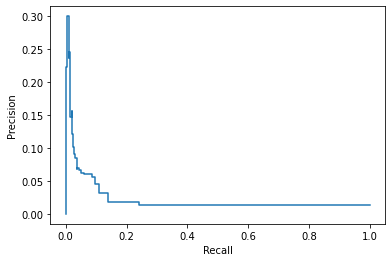

In [33]:
import numpy as np
# precision = np.append(precision, [1])
print(precision)
print(recall)
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

## Prediction and Prediction Explainability 

In the next section we'll generate some predictions for the SCL test set. With these predictions, we'll also produce shap values to explain the predicitions. First we produce shap plots locally to the remote machine and pull back the created image. This plot includes the data values in the heatmap. This is to be used for diagnosing performance of the model.

The second shap function performs shap analysis remotely using the test set and pulls back the shap values, base_values and model expected value to be used on the orchestrator side. We use this to produce the prediction output with shap values csv deliverable.

### SHAP Plot for model diagnosis

348.7483170032501


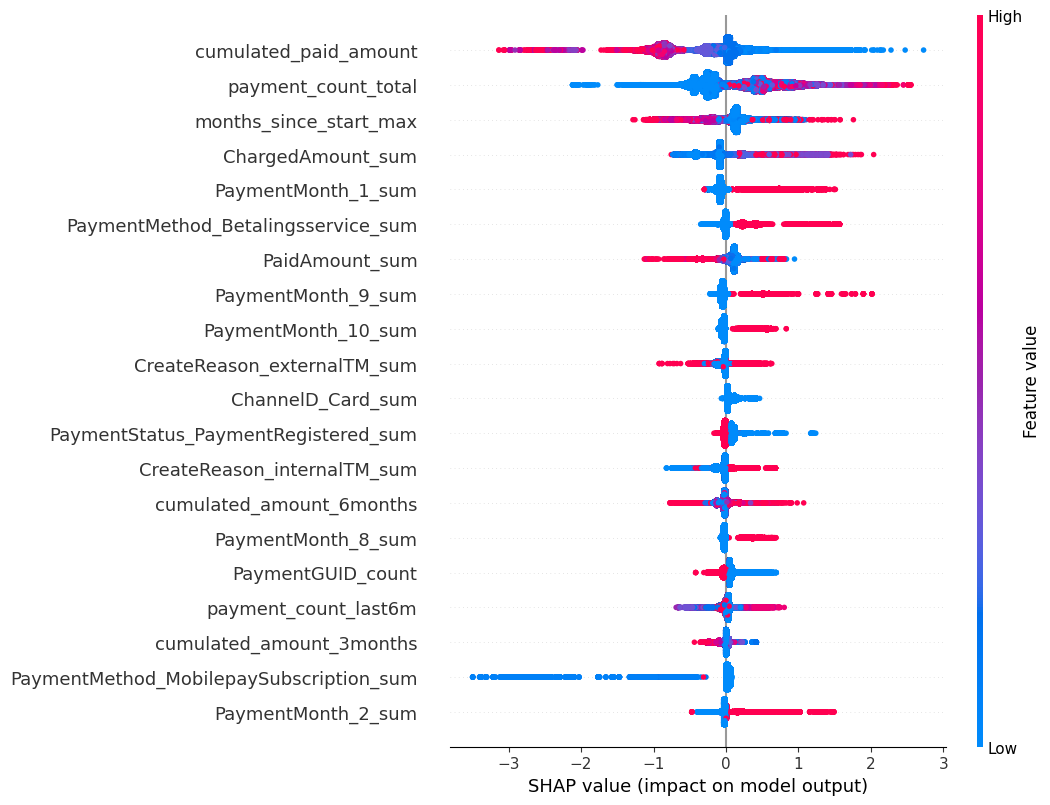

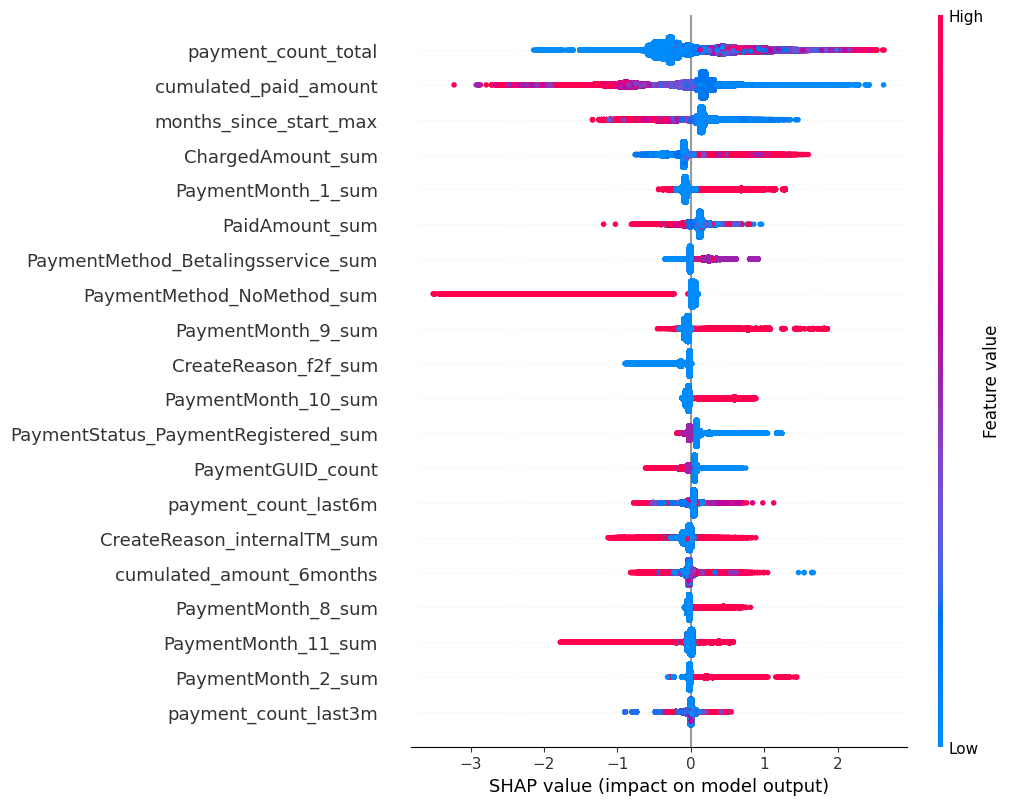

In [34]:
#For each dataset, generate shap images on the local machine, pull back the plots that were generated

start_time = time.time()

model.shap(X_test)

print(time.time() - start_time)

### Create Prediction and Shap Values CSV for GFR

In [35]:
from sail.tmp import shap_private, get_tmp_fns

tmp_fns = get_tmp_fns()

In [36]:
for vm in vmids:
        for key in tmp_fns:
            pushsafeobj(vm, tmp_fns[key])

In [37]:
preds = model.predict(X_test)

In [38]:
import pandas as pd

y_test_df = RemoteDataFrame(vmids[0], y_test[0], fns)
lab = y_test_df.value_counts()
temp_index = y_test_df.index
temp_index

explanation_values, explanation_base_values, expected_value = shap_private(vmids[0], best_model, X_test[0], tmp_fns)

customer_guid = []
date = []
for i in range(0, len(temp_index)):
    customer_guid.append(temp_index[i][0])
    date.append(temp_index[i][1])

# Add references to customer instances
df1 = pd.DataFrame()
df1['CustomerGUID'] = customer_guid
df1['Date'] = date

#add predictions
df1['Predictions Probabilities'] = 1/(1+ np.exp(-preds[0]))
df1['Predictions Log Odds'] = preds[0]
df1['SHAP Base Values'] = explanation_base_values

#Add Explanation Values
df2 = pd.DataFrame()
df2 = pd.DataFrame(explanation_values)
df2.columns = cols
results_for_csv = pd.concat([df1, df2], axis=1, join='inner')
results_for_csv.to_csv('./predictions_federated_shap_GFR_test.csv')
results_for_csv.head()

['{1447F7EA-4C69-4402-8811-4F3B31AABD26}']


,CustomerGUID,Date,Predictions Probabilities,Predictions Log Odds,SHAP Base Values,Age_max,ChargedAmount_sum,PostalCode_max,PaidAmount_sum,AgreementGUID_count,...,PaymentMonth_9_sum,PaymentMonth_10_sum,PaymentMonth_11_sum,PaymentMonth_12_sum,cumulated_paid_amount,cumulated_amount_3months,cumulated_amount_6months,payment_count_last3m,payment_count_last6m,payment_count_total
0,000042c4-ee04-e811-8112-5065f38be571,2020-01-01,0.004947,-5.303981,-4.698404,0.0,0.006956,0.0,-0.151707,0.005620,...,-0.072735,-0.108623,-0.060306,0.0,0.089104,-0.011701,-0.052487,0.046428,0.008333,-0.297849
1,000042c4-ee04-e811-8112-5065f38be571,2020-02-01,0.008055,-4.813372,-4.698404,0.0,-0.088095,0.0,0.124856,-0.002462,...,-0.076437,-0.057443,-0.035320,0.0,0.158344,-0.002964,-0.022821,-0.003523,0.042090,-0.464924
2,000042c4-ee04-e811-8112-5065f38be571,2020-03-01,0.007076,-4.943876,-4.698404,0.0,0.211336,0.0,-0.082549,0.008116,...,-0.037228,-0.031217,0.004404,0.0,0.037851,-0.041600,-0.119372,0.027938,0.030926,0.199344
3,000042c4-ee04-e811-8112-5065f38be571,2020-04-01,0.009553,-4.641326,-4.698404,0.0,-0.313421,0.0,0.295510,-0.003791,...,-0.045966,-0.032517,-0.002951,0.0,0.130324,0.001130,-0.085591,-0.063234,0.063537,-0.146186
4,000042c4-ee04-e811-8112-5065f38be571,2020-05-01,0.007178,-4.929480,-4.698404,0.0,-0.335829,0.0,0.255780,-0.003791,...,-0.045978,-0.032546,-0.002978,0.0,0.100339,0.001426,-0.085816,-0.077917,0.062378,-0.156976


In [39]:
expected_value

-4.698404

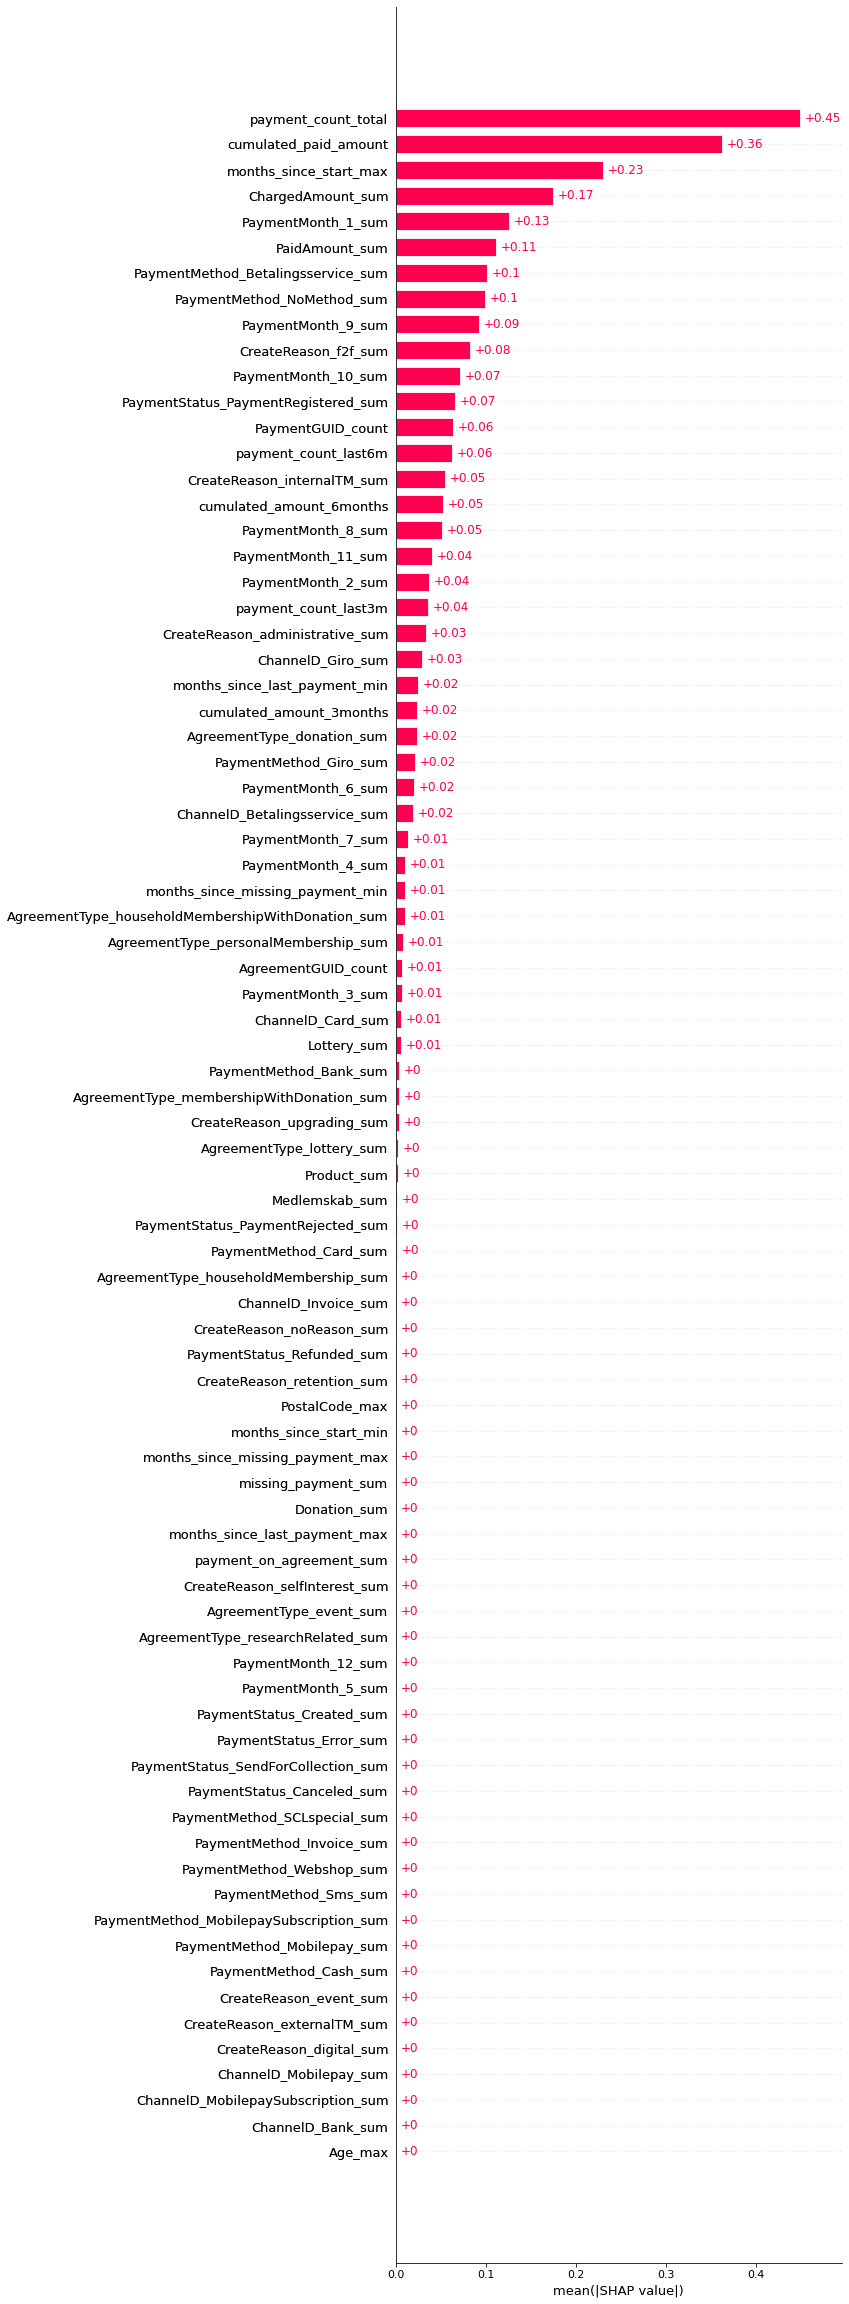

None


elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


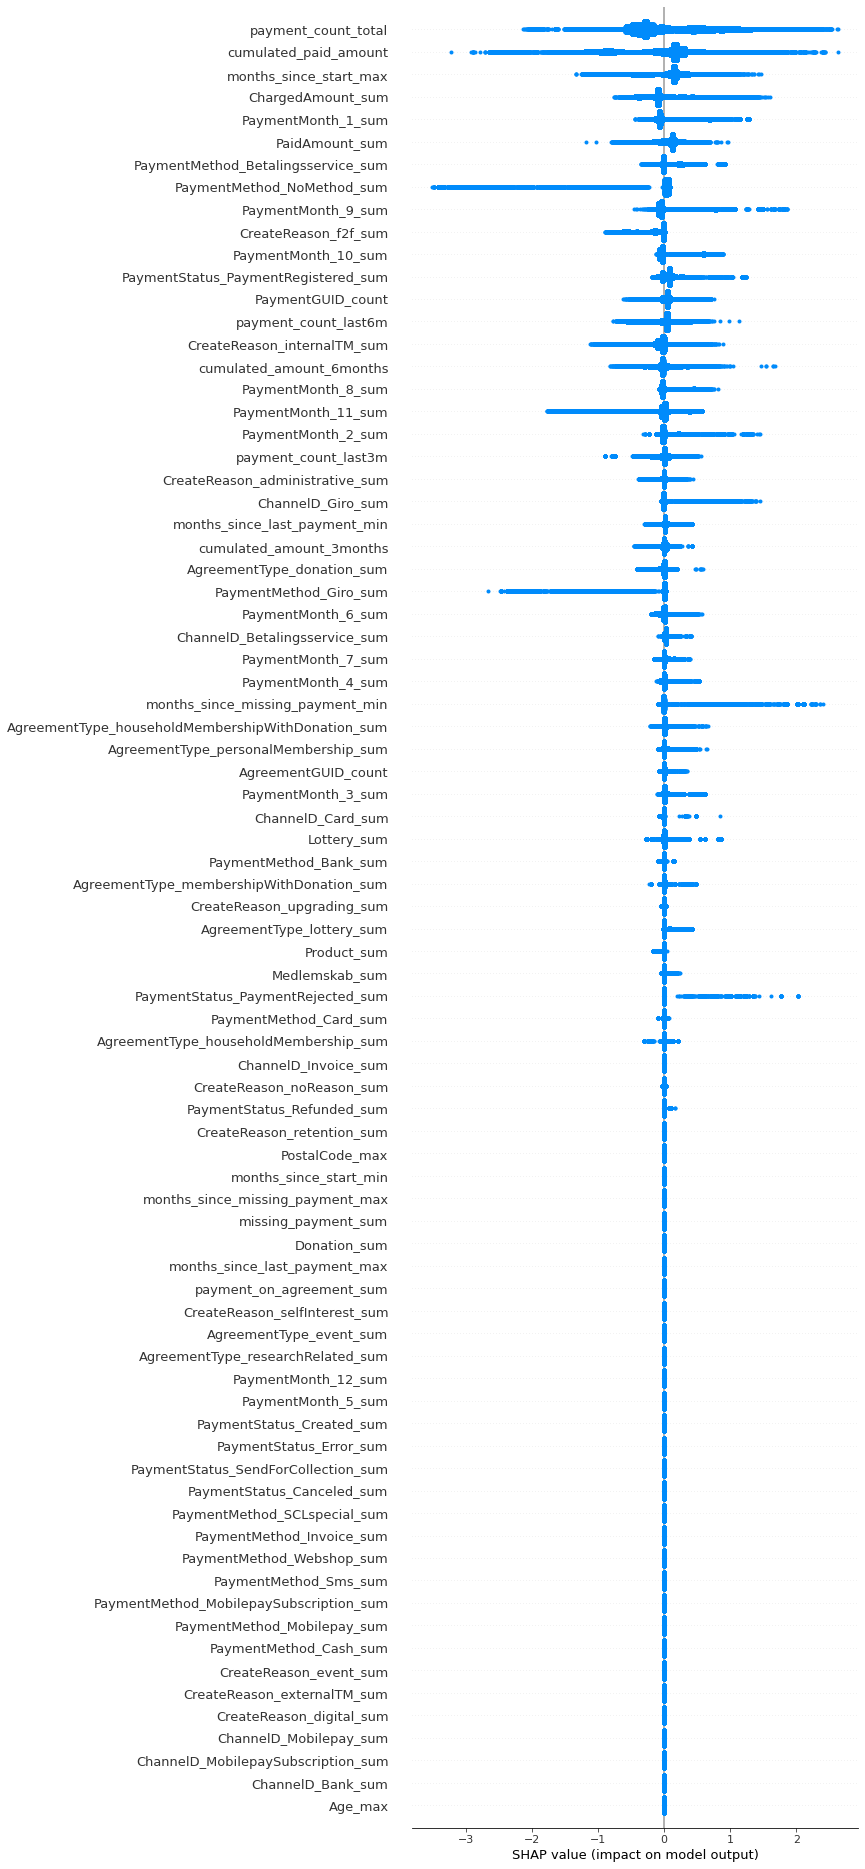

None


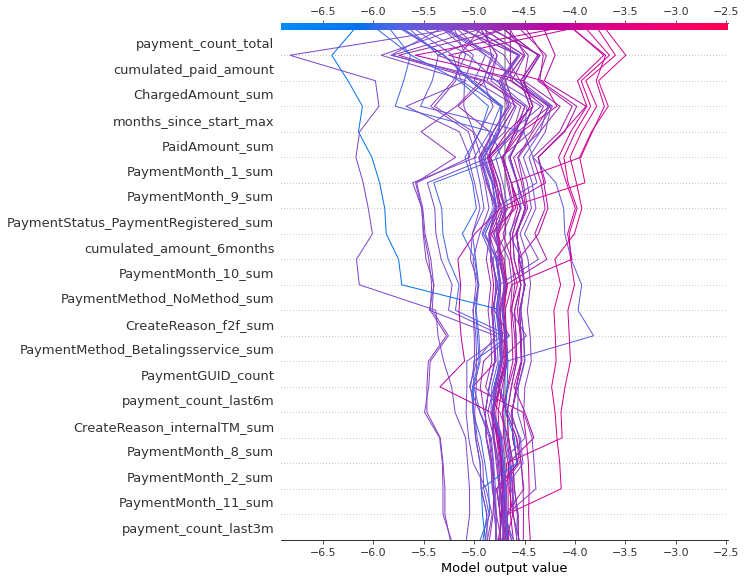

None


In [40]:
import shap

explanation = shap.Explanation(explanation_values, base_values=explanation_base_values, feature_names=cols)
print(shap.plots.bar(explanation, max_display=len(cols)))
print(shap.plots.beeswarm(explanation, max_display=len(cols)))
print(shap.decision_plot(expected_value, explanation.values[:50], cols))

### Display shap values for model analysis SCL

In [41]:

y_test_df = RemoteDataFrame(vmids[1], y_test[1], fns)
lab = y_test_df.value_counts()
temp_index = y_test_df.index
temp_index

explanation_values, explanation_base_values, expected_value = shap_private(vmids[1], best_model, X_test[1], tmp_fns)

customer_guid = []
date = []
for i in range(0, len(temp_index)):
    customer_guid.append(temp_index[i][0])
    date.append(temp_index[i][1])

# Add references to customer instances
df1 = pd.DataFrame()
df1['CustomerGUID'] = customer_guid
df1['Date'] = date

#add predictions
df1['Predictions Probabilities'] = 1/(1+ np.exp(-preds[1]))
df1['Predictions Log Odds'] = preds[1]
df1['SHAP Base Values'] = explanation_base_values

#Add Explanation Values
df2 = pd.DataFrame()
df2 = pd.DataFrame(explanation_values)
df2.columns = cols
results_for_csv = pd.concat([df1, df2], axis=1, join='inner')
results_for_csv.to_csv('./predictions_federated_shap_SCL_test.csv')
results_for_csv.head()

['{5D900932-92F8-4339-9503-24CC0EED0F23}']


,CustomerGUID,Date,Predictions Probabilities,Predictions Log Odds,SHAP Base Values,Age_max,ChargedAmount_sum,PostalCode_max,PaidAmount_sum,AgreementGUID_count,...,PaymentMonth_9_sum,PaymentMonth_10_sum,PaymentMonth_11_sum,PaymentMonth_12_sum,cumulated_paid_amount,cumulated_amount_3months,cumulated_amount_6months,payment_count_last3m,payment_count_last6m,payment_count_total
0,000226bd-8955-4e94-becd-47ff50c1704c,2020-10-01,0.000434,-7.743078,-4.698404,0.0,-0.077207,0.0,0.009425,-0.014306,...,-0.060477,0.407389,-0.014557,0.0,-2.453694,0.001659,-0.011571,0.036693,0.043413,-0.922017
1,000226bd-8955-4e94-becd-47ff50c1704c,2020-11-01,0.000590,-7.435605,-4.698404,0.0,-0.082906,0.0,0.099271,-0.001882,...,-0.066971,-0.034881,0.357646,0.0,-2.182947,0.002195,0.005759,0.037477,-0.004924,-1.073351
2,000226bd-8955-4e94-becd-47ff50c1704c,2020-12-01,0.000269,-8.221089,-4.698404,0.0,-0.077317,0.0,0.091252,-0.002569,...,-0.065516,-0.047812,-0.026910,0.0,-2.238747,-0.170084,-0.018794,-0.024819,-0.004989,-1.088741
3,000226bd-8955-4e94-becd-47ff50c1704c,2021-01-01,0.000646,-7.343865,-4.698404,0.0,-0.066709,0.0,0.091568,-0.002609,...,-0.045613,-0.052011,-0.033315,0.0,-2.355418,0.002832,0.024254,0.086830,0.001264,-1.190841
4,000226bd-8955-4e94-becd-47ff50c1704c,2021-02-01,0.000202,-8.508218,-4.698404,0.0,-0.076724,0.0,0.096355,-0.002609,...,-0.065169,-0.056868,-0.034062,0.0,-2.460048,-0.000910,0.003597,0.030405,-0.006775,-1.300251


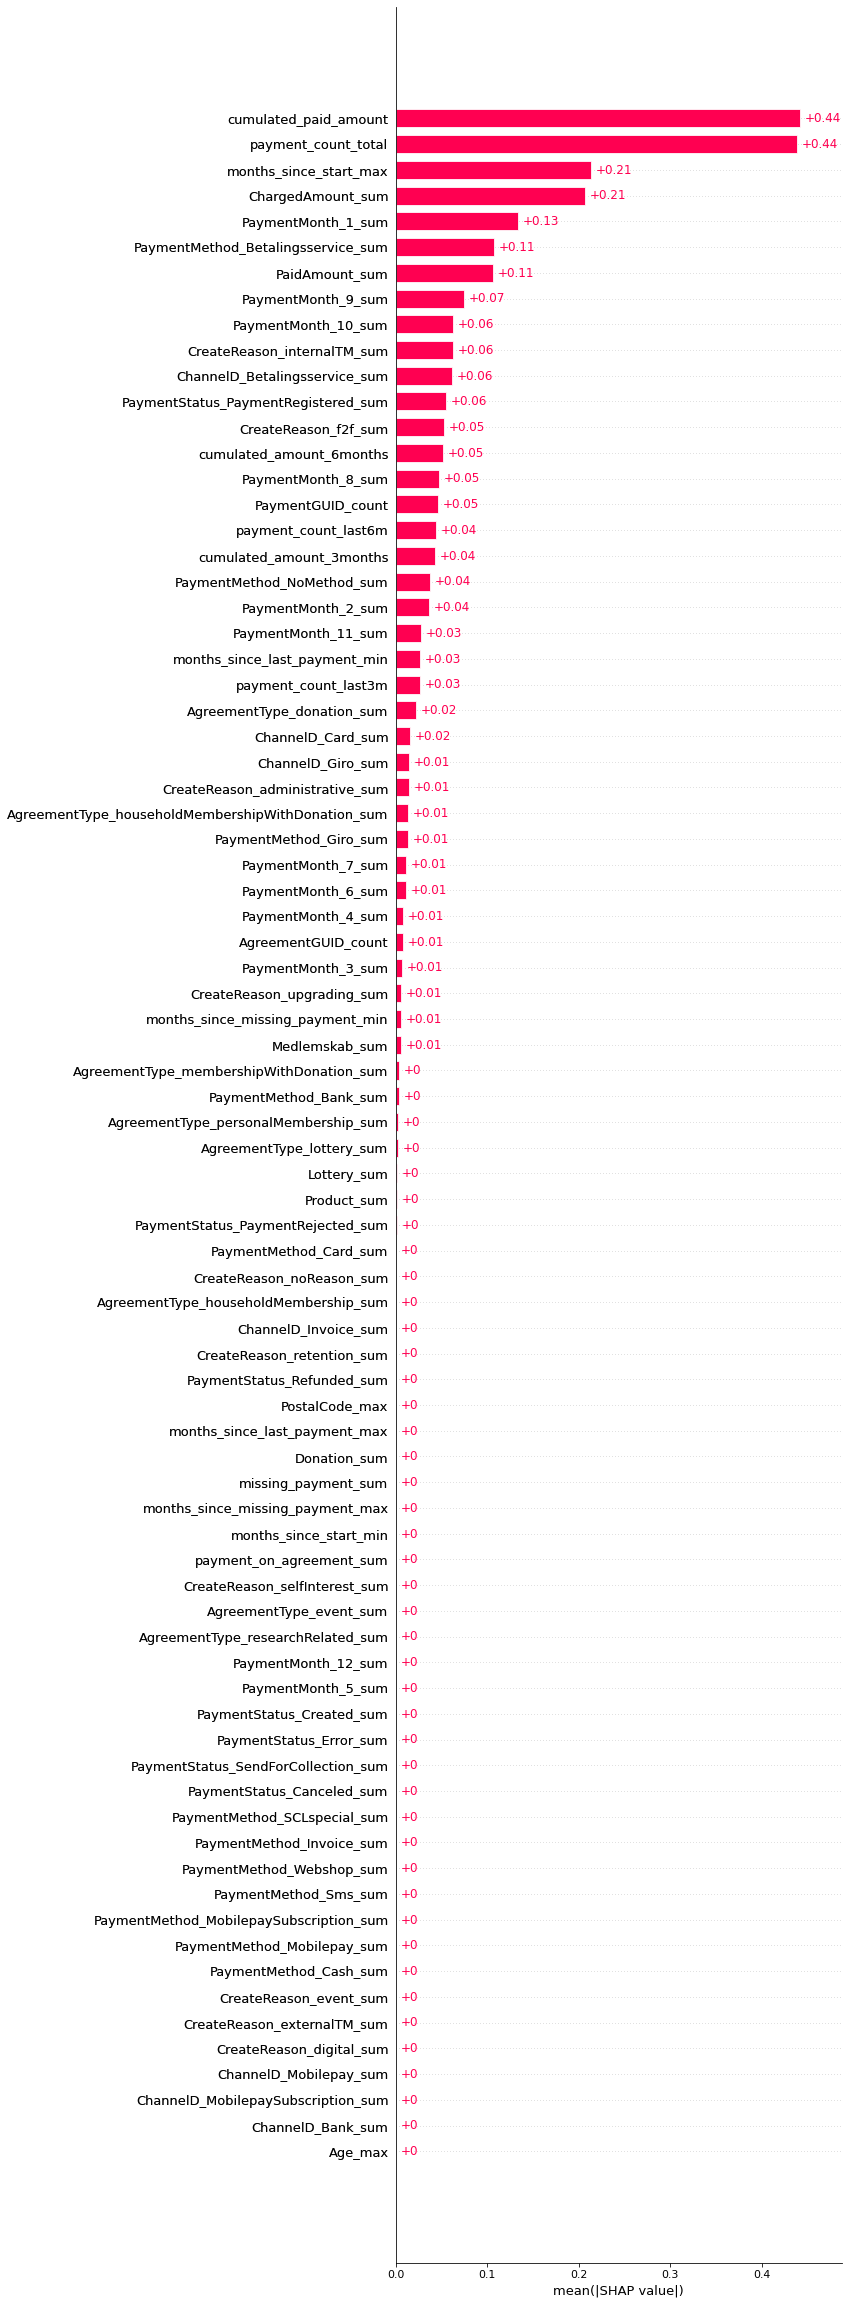

None


elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


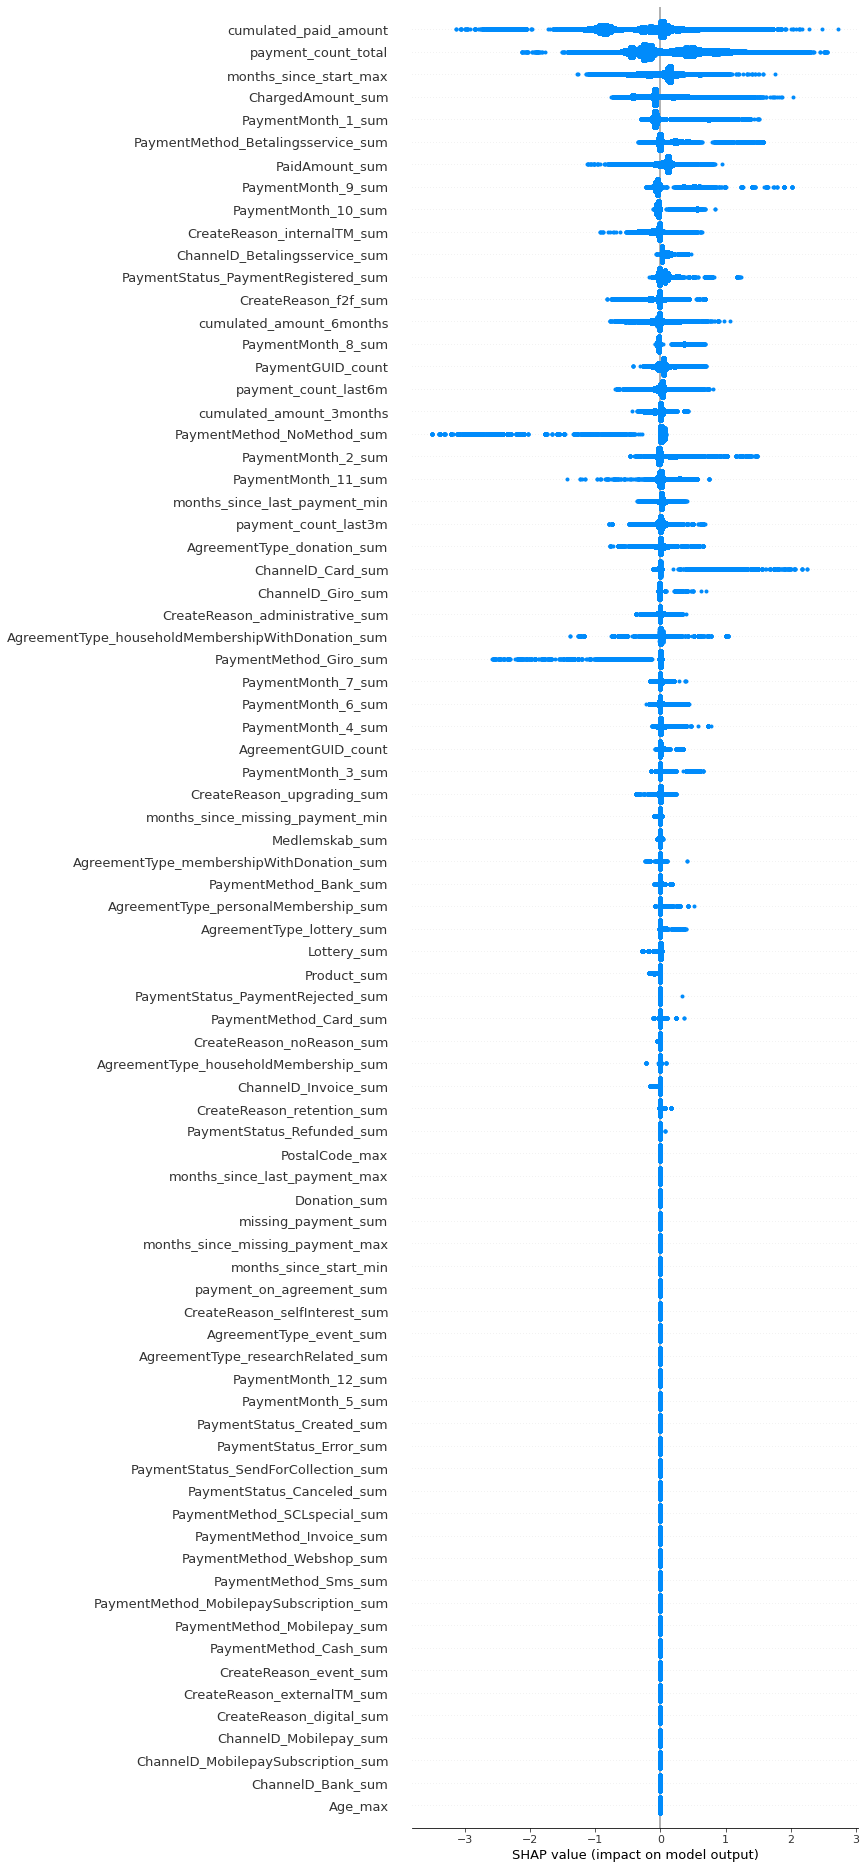

None


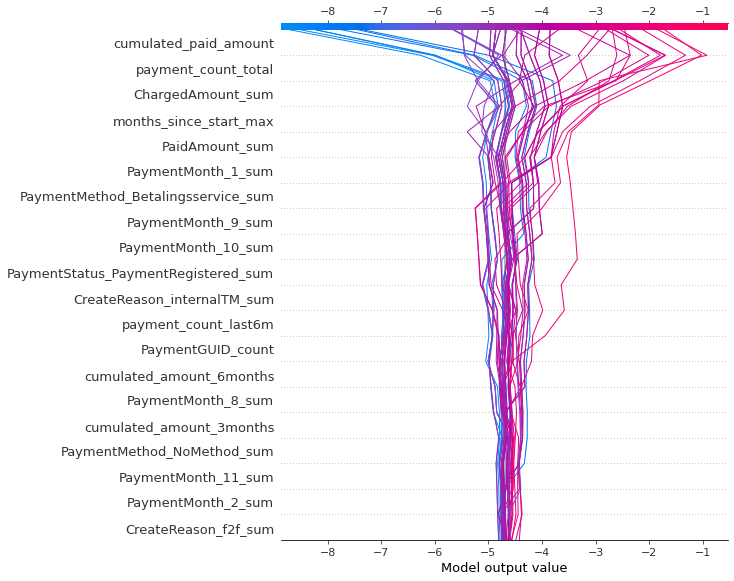

None


In [42]:
explanation = shap.Explanation(explanation_values, base_values=explanation_base_values, feature_names=cols)
print(shap.plots.bar(explanation, max_display=len(cols)))
print(shap.plots.beeswarm(explanation, max_display=len(cols)))
print(shap.decision_plot(expected_value, explanation.values[:50], cols))